# 3A.mr - PIG et Paramètres (Cloudera) (correction)

Correction.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Connexion au cluster

On prend le cluster [Cloudera](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td3a_cenonce_session6.html#p2). Il faut exécuter ce script pour pouvoir notifier au notebook que la variable ``params`` existe.

In [2]:
import pyensae
from pyquickhelper.ipythonhelper import open_html_form
params={"server":"df...fr", "username":"", "password":""}
open_html_form(params=params,title="server + credentials", key_save="params")

In [3]:
import pyensae
%load_ext pyensae
%load_ext pyenbc
password = params["password"]
server = params["server"]
username = params["username"]
client = %remote_open
client

## Exercice 1 : min, max

On ajoute deux paramètres pour construire l'histogramme entre deux valeurs ``a``,``b``. Ajouter ces deux paramètres au nom du fichier de sortie peut paraître raisonnable mais l'interpréteur a du mal à identifier les paramètres ``Undefined parameter : bins_``. On utilise des tirets.

In [4]:
%%PIG histogramab.pig

values = LOAD 'random/random.sample.txt' USING PigStorage('\t') AS (x:double);

values_f = FILTER values BY x >= $a AND x <= $b ;   -- ligne ajoutée

values_h = FOREACH values_f GENERATE x, ((int)(x / $bins)) * $bins AS h ;

hist_group = GROUP values_h BY h ;

hist = FOREACH hist_group GENERATE group, COUNT(values_h) AS nb ;

STORE hist INTO 'random/histo_$bins-$a-$b.txt' USING PigStorage('\t') ;

In [5]:
if client.dfs_exists("random/histo_0.1-0.2-0.8.txt"):
    client.dfs_rm("random/histo_0.1-0.2-0.8.txt", recursive=True)

In [6]:
client.pig_submit("histogramab.pig", redirection="redirection", 
                  params =dict(bins="0.1", a="0.2", b="0.8") )

('', '')

In [7]:
%remote_cmd tail redirection.err

In [8]:
%dfs_ls random

,attributes,code,alias,folder,size,date,time,name,isdir
0,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-12-03,22:55,random/histo_0.1-0.2-0.8.txt,True
1,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-11-28,00:11,random/histo_0.1.txt,True
2,-rw-r--r--,3,xavierdupre,xavierdupre,202586,2014-11-27,23:38,random/random.sample.txt,False


In [9]:
if os.path.exists("histo.txt") : os.remove("histo.txt")
client.download_cluster("random/histo_0.1-0.2-0.8.txt","histo.txt", merge=True)

'random/histo_0.1-0.2-0.8.txt'

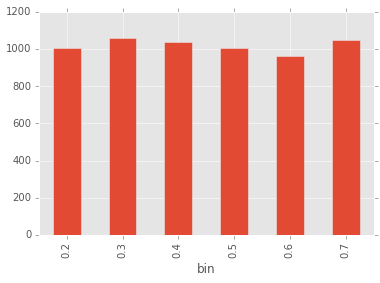

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas
df = pandas.read_csv("histo.txt", sep="\t",names=["bin","nb"])
df.plot(x="bin",y="nb",kind="bar")